# Python深度学习-基于Pytorch

## 使用numpy模拟机器学习

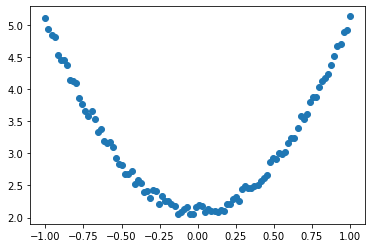

In [88]:
#! /user/bin/env python3
# -*- coding: utf-8 -*-


import numpy as np
from matplotlib import pyplot as plt


# 固定随机数种子
np.random.seed(100)
# 生成一份训练数据
x = np.linspace(-1, 1, 100).reshape(100, 1)
# 在标准数据上加上一些噪声，数据抖动
y = 3*np.power(x, 2) + 2 + 0.2*np.random.rand(x.size).reshape(100, 1)
# print(x)
# print(y)

plt.scatter(x, y)
plt.show()

In [89]:
# 随机初始化参数
w1 = np.random.rand(1, 1)
b1 = np.random.rand(1, 1)

# 学习率
lr = 0.001

for i in range(800):
    # 向前传播
    y_pred = np.power(x, 2) * w1 + b1
    # 定义损失函数
    loss = 0.5 * (y_pred - y) ** 2
    loss = loss.sum()

    # 计算梯度
    grad_w = np.sum((y_pred - y)*np.power(x, 2))
    grad_b = np.sum((y_pred - y))
    # 使用梯度下降法，使loss最小
    w1 -= lr * grad_w
    b1 -= lr * grad_b

    jd = i/800
    print("训练进度%.2f，loss：%f" % (jd, loss), end='\r')
print()
print(w1, b1)

训练进度1.00，loss：0.166980
[[2.98927619]] [[2.09818307]]


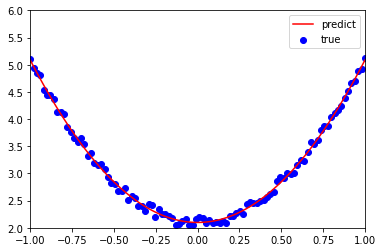

In [90]:
# 展示训练成果
plt.plot(x, y_pred, 'r-', label='predict')
# 展示训练数据
plt.scatter(x, y, color='blue', marker='o', label='true')
plt.xlim(-1, 1)
plt.ylim(2, 6)
plt.legend()
plt.show()

## 使用Tensor和Antograd实现机器学习

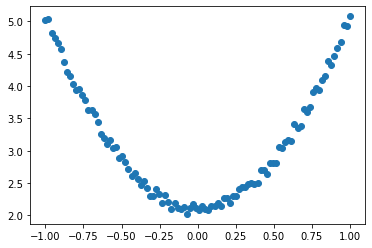

In [91]:
import torch


# 初始化随机种子
torch.manual_seed(100)

# 生成训练数据
x = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)
y = 3*x.pow(2) + 2 + 0.2*torch.rand(x.size())           # 在标准结果上加上一些噪声，产生一定的数据抖动

# 展示数据点图
plt.scatter(x.numpy(), y.numpy())
plt.show()

In [92]:
# 随机初始化参数，参数w，b是需要学习的，故需设置requires_grad=True
w = torch.randn(1, 1, dtype=torch.float, requires_grad=True)
b = torch.randn(1, 1, dtype=torch.float, requires_grad=True)

# 学习率
lr = 0.001

for li in range(8000):
    # 向前传播
    y_pred = x.pow(2).mm(w) + b
    # 定义损失函数
    loss = 0.5 * (y_pred - y) ** 2
    loss = loss.sum()
    
    # 自动计算梯度，梯度存放在grad属性中
    loss.backward()

    # 手动更新参数，需要用torch.no_grad()，在上下文管理器中切断自动求导的计算
    with torch.no_grad():
        w -= lr * w.grad
        b -= lr * b.grad

        # 梯度清零
        w.grad.zero_()
        b.grad.zero_()
    jd = li/8000
    print("训练进度%.2f，loss：%f" % (jd, loss), end='\r')
print()
print(w, b)

训练进度1.00，loss：0.166769
tensor([[2.9668]], requires_grad=True) tensor([[2.1138]], requires_grad=True)


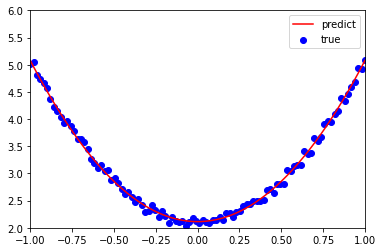

In [93]:
# 展示训练结果
plt.plot(x.numpy(), y_pred.detach().numpy(), 'r-', label="predict")
plt.scatter(x.numpy(), y.numpy(), color='blue', marker='o', label='true')
plt.xlim(-1, 1)
plt.ylim(2, 6)
plt.legend()
plt.show()

## 实现神经网络实例

### 背景说明

利用神经网络完成对手写数字进行识别，来说明如何借助nn工具箱来实现一个神经网络。并对nn的各个模块进行详细介绍。环境PyTorch1.0+，gpu或者cpu。数据集为MNIST。

+ **主要步骤**

1）利用pytorch内置函数mnist下载数据

2）利用torchvision对数据进行预处理，调用torch.utils建立一个数据迭代器

3）可视化源数据

4）利用nn工具箱构建神经网络模型

5）实例化模型，并定义损失函数及优化器

6）训练模型

7）可视化结果

In [94]:
import numpy as np
import torch
from torchvision.datasets import mnist
# 倒入预处理模块
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
# 倒入nn及优化器
import torch.nn.functional as F
import torch.optim as optim
from torch import nn


# 定义一些超参数
train_batch_size = 64
test_batch_size = 128
learning_rate = 0.01
num_epoches = 20
lr = 0.01
momentum = 0.5


# 定义预处理函数，一次放在Compose函数中（预处理函数对数据集进行处理）
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
# 下载数据，并对数据进行预处理
train_dataset = mnist.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = mnist.MNIST('./data', train=False, transform=transform)
# dataloader是一个可迭代对象，可以使用迭代器一样使用
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)
print("done")

done


**【说明】**

1）transfors.Compose可以把一些转换函数组合在一起

2）Normalize(\[0.5\], \[0.5\])对张量进行归一化，这里两个0.5分别表示对张量进行归一化的全局平均值和方差。因图像是灰色的只有一个通道，如果有多个通道，需要有多个数字，如3个通道，应该是Nomaliz(\[m1, m2, m3\], \[n1, n2, n3\])

3）downloa参数控制是否下载，如果./data目录下已有MNIST，可选择False

4）用DataLoader得到生成器，这可以节省内存

5）torchvision及data的使用稍后详解

### 可视化数据源

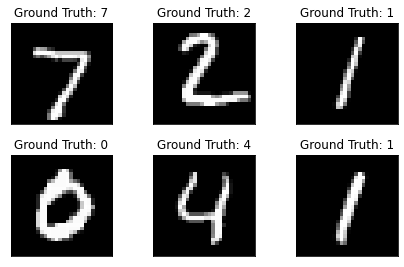

In [95]:
import matplotlib.pyplot as plt


# 枚举批次和测试数据
examples = enumerate(test_loader)
# 解包批次，测试数据，和数据标签。每批次数据中一个标签对应多个图像，每个图像是28X28像素大小
# example_data是一个[128, 1, 28, 28]的张量，即包含128个28X28的图像
# example_target是一个一维的包含128个标签的张量
batch_idx, (example_data, example_target) = next(examples)
# print(test_dataset[1])
# print(batch_idx)
# print(example_data[0, 0].size())
# print(example_target)

fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i, 0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_target[i]))
    plt.xticks([])
    plt.yticks([])

### 构建模型

1）构建网络

In [96]:
class Net(nn.Module):
    """
    使用sequential构建网络，Sequential（）函数的功能是将网络的层组合到一起
    """
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1), nn.BatchNorm1d(n_hidden_1))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2), nn.BatchNorm1d(n_hidden_2))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim))

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

### 实例化网络

In [97]:
# 检测是否有可用的GPU，否则使用CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 实例化网络
model = Net(28*28, 300, 100, 10)
# 计算转移至自定义设备
model.to(device=device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

## 训练模型

### 1.训练模型 

In [98]:
# 开始训练
losses = []
acces = []
eval_losses = []
eval_acces = []

for epoch in range(num_epoches):
    train_loss = 0
    train_acc = 0
    model.train()
    # 动态修改参数学习率
    if epoch%5 == 0:
        optimizer.param_groups[0]['lr'] *= 0.1

    for img, label in train_loader:
        img = img.to(device)
        label = label.to(device)
        # 这里要把图片展开[1, 28, 28]->[1, 28*28]
        img = img.view(img.size(0), -1)
        # 向前传播
        out = model(img)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        # 计算分类的准确率
        _, pred = out.max(1)
        num_corrent = (pred == label).sum().item()
        acc = num_corrent / img.shape[0]
        train_acc += acc

    losses.append(train_loss / len(train_loader))
    acces.append(train_acc / len(train_loader))

    # 在测试集上检验效果
    eval_loss = 0
    eval_acc = 0
    # 将模式改为预测模式
    model.eval()
    for img, label in test_loader:
        img = img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        out = model(img)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)
        num_corrent = (pred == label).sum().item()
        acc = num_corrent / img.shape[0]
        eval_acc += acc

    eval_losses.append(eval_loss / len(test_loader))
    eval_acces.append(eval_acc / len(test_loader))

    print("epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}".format(
        epoch, train_loss/len(train_loader), train_acc/len(train_loader), eval_loss/len(test_loader), eval_acc/len(test_loader)
    ))

epoch: 0, Train Loss: 1.0273, Train Acc: 0.7856, Test Loss: 0.5550, Test Acc: 0.8959
epoch: 1, Train Loss: 0.4841, Train Acc: 0.8990, Test Loss: 0.3567, Test Acc: 0.9223
epoch: 2, Train Loss: 0.3531, Train Acc: 0.9186, Test Loss: 0.2758, Test Acc: 0.9362
epoch: 3, Train Loss: 0.2861, Train Acc: 0.9310, Test Loss: 0.2308, Test Acc: 0.9445
epoch: 4, Train Loss: 0.2434, Train Acc: 0.9406, Test Loss: 0.1997, Test Acc: 0.9512
epoch: 5, Train Loss: 0.2233, Train Acc: 0.9454, Test Loss: 0.1956, Test Acc: 0.9524
epoch: 6, Train Loss: 0.2203, Train Acc: 0.9463, Test Loss: 0.1944, Test Acc: 0.9529
epoch: 7, Train Loss: 0.2181, Train Acc: 0.9465, Test Loss: 0.1920, Test Acc: 0.9536
epoch: 8, Train Loss: 0.2155, Train Acc: 0.9470, Test Loss: 0.1897, Test Acc: 0.9537
epoch: 9, Train Loss: 0.2131, Train Acc: 0.9471, Test Loss: 0.1874, Test Acc: 0.9543
epoch: 10, Train Loss: 0.2109, Train Acc: 0.9492, Test Loss: 0.1846, Test Acc: 0.9538
epoch: 11, Train Loss: 0.2096, Train Acc: 0.9487, Test Loss: 0.1

### 2.可视化训练及测试损失值

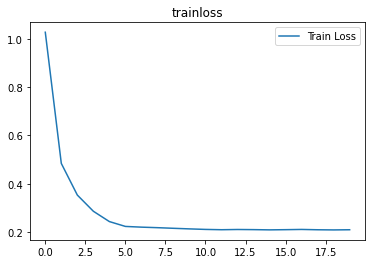

In [99]:
plt.title("trainloss")
plt.plot(np.arange(len(losses)), losses)
plt.legend(["Train Loss"], loc="upper right")

In [136]:
d = test_dataset[0][0]
t = test_dataset[0][1]
print(d.size())
d = d.view(d.size(0), -1)
print(d.size())
# out = model(d)
# print(out.max(1))

torch.Size([1, 28, 28])
torch.Size([1, 784])
